# Model training and evaluation

## Imports and dependencies

In [1]:
import configparser, json, os, random
import tensorflow as tf
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import ReduceLROnPlateau
from model_builder import ModelBuilder
from data_generator import DataGenerator
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### GPU availability

In [2]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


## Configuration of keras callbacks

In [2]:
config = configparser.ConfigParser()
config.read('training_config.ini')
config.sections()

callbacks = []
if json.loads(config['DEFAULT']['use_csv_logger']):
    csv_logger = CSVLogger('testlog.csv', append=True, separator=';')
    callbacks.append(csv_logger)

if json.loads(config['DEFAULT']['use_model_checkpoint']):
    mode    = config['model-checkpoint']['mode']
    monitor = config['model-checkpoint']['monitor']
    sbo     = config['model-checkpoint']['save_best_only']
    file_p  = config['model-checkpoint']['file_path']
    mcp_save = ModelCheckpoint(file_p, save_best_only=sbo, monitor=monitor, mode=mode)
    callbacks.append(mcp_save)

if json.loads(config['DEFAULT']['use_early_stopping']):
    mode     = config['early-stopping']['mode']
    monitor  = config['early-stopping']['monitor']
    patience = json.loads(config['early-stopping']['patience'])
    early_stopping = EarlyStopping(monitor=monitor, patience=patience, mode=mode)
    callbacks.append(early_stopping)

if json.loads(config['DEFAULT']['use_reduce_lr_loss']):
    mode     = config['reduce-lr-loss']['mode']
    monitor  = config['reduce-lr-loss']['monitor']
    factor   = json.loads(config['reduce-lr-loss']['factor'])
    patience = json.loads(config['reduce-lr-loss']['patience'])
    eps      = json.loads(config['reduce-lr-loss']['epsilon'])
    reduce_lr_loss = ReduceLROnPlateau(monitor=monitor, factor=factor, patience=patience, epsilon=eps, mode=mode)
    callbacks.append(reduce_lr_loss)

## Setting up data and parameters

In [3]:
# Default configdata
train_data_dir = config['DEFAULT']['train_data']
test_data_dir  = config['DEFAULT']['test_data']
classes        = json.loads(config['DEFAULT']['classes'])

# Model-parameters configdata TODO - Maybe change the val-range implementation
curr_model  = config['model-parameters']['model']
data_shape  = json.loads(config['model-parameters']['input_shape'])
n_channels  = json.loads(config['model-parameters']['n_channels'])
input_shape = tuple(data_shape + [n_channels])

#Optimizer-hyperparameters configdata
optimizer  = config['optimizer-hyperparameters']['optimizer']
loss       = config['optimizer-hyperparameters']['loss']
lr         = json.loads(config['optimizer-hyperparameters']['learning_rate'])

batch_size = json.loads(config['optimizer-hyperparameters']['batch_size'])
epochs     = json.loads(config['optimizer-hyperparameters']['epochs'])
steps      = json.loads(config['optimizer-hyperparameters']['steps_per_epoch'])
metrics    = json.loads(config['optimizer-hyperparameters']['metrics'])

## Model training

In [4]:
model = ModelBuilder(curr_model, classes, input_shape=input_shape)

'Load pre-trained weights if wanted'
if json.loads(config['DEFAULT']['use_load_weights']):
    weight_folder = config['load-weights']['weights_folder']
    weights       = config['load-weights']['weights']
    model.load_weights(os.path.join(weight_folder, weights))

train_data = os.listdir(train_data_dir)
data_len   = len(train_data)

random.shuffle(train_data)

val_range  = json.loads(config['model-parameters']['val_range'])
train_data = train_data[int(data_len * val_range) + 1:]
val_data   = train_data[:int(data_len * val_range)]

train_datagen = DataGenerator(train_data_dir, train_data, classes, 
                              n_channels=n_channels, dim=data_shape, 
                              batch_size=batch_size, rescale=255)

val_datagen = DataGenerator(train_data_dir, val_data, classes,
                            n_channels=n_channels, dim=data_shape, 
                            batch_size=batch_size, rescale=255)

model.compile_model(optimizer=optimizer, 
                    loss=loss, 
                    metrics=metrics, 
                    learning_rate=lr)

history = model.fit_model(
          train_gen=train_datagen,
          val_gen=val_datagen,
          steps_per_epoch=steps, 
          val_steps_per_epoch=steps,
          epochs=epochs,
          callbacks=callbacks)

(128, 128, 4)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg16_bn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 4)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      2368      
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 128, 128, 64)      256       
_________________________________________________________________
block1_act1 (Activation)     (None, 128, 128, 64)      0         
_________________________________________________________________
block1_dropout1 (Dropout)    (None, 128, 128, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
____________________________

/usr/local/lib/python3.5/dist-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1/50
25/25 [==============================] - 17s 672ms/step - loss: 1.3912 - acc: 0.4981 - val_loss: 1.4005 - val_acc: 0.5412
Epoch 2/50
25/25 [==============================] - 10s 399ms/step - loss: 1.2133 - acc: 0.5344 - val_loss: 0.9216 - val_acc: 0.5456
Epoch 3/50
25/25 [==============================] - 10s 405ms/step - loss: 1.2536 - acc: 0.5462 - val_loss: 1.2888 - val_acc: 0.4275
Epoch 4/50
25/25 [==============================] - 9s 353ms/step - loss: 1.1623 - acc: 0.5606 - val_loss: 1.4441 - val_acc: 0.5094
Epoch 5/50
25/25 [==============================] - 10s 418ms/step - loss: 1.1278 - acc: 0.5688 - val_loss: 1.9245 - val_acc: 0.4306
Epoch 6/50
25/25 [==============================] - 10s 417ms/step - loss: 1.1821 - acc: 0.5431 - val_loss: 1.2017 - val_acc: 0.5869
Epoch 7/50
25/25 [==============================] - 10s 418ms/step - loss: 1.0920 - acc: 0.5894 - val_loss: 0.9612 - val_acc: 0.6012
Epoch 8/50
25/25 [==============================] - 10s 381ms/step - l

# Model evaluation

### Class count

In [16]:
cnt = {}
i = 0
for c in classes:
    cnt[c] = 0
    
files = test_data

for f in files:
    i+=1
    for c in classes:
        if c in f:
            cnt[c] += 1

print(i, cnt)

1552 {'parking': 260, 'parque': 283, 'industrial': 219, 'commercial': 217, 'forest': 285, 'residential': 288}


## Test data prediction

Running prediction on the best weights for the current model

In [17]:
model = ModelBuilder(curr_model, classes, input_shape=input_shape)

'Loading the best weights for the trained model to be evaluated'
weight_folder = config['load-weights']['weights_folder']
weights =  config['load-weights']['weights']
model.load_weights(os.path.join(weight_folder, weights))

train_data = os.listdir(train_data_dir)
data_len   = len(train_data)

random.shuffle(train_data)

val_range  = json.loads(config['model-parameters']['val_range'])
train_data = train_data[int(data_len * val_range) + 1:]
val_data   = train_data[:int(data_len * val_range)]

val_datagen = DataGenerator(train_data_dir, val_data, classes, test=True,
                             n_channels=n_channels, dim=data_shape, 
                             batch_size=5)
test_data = os.listdir(test_data_dir)
test_datagen = DataGenerator(test_data_dir, test_data, classes, test=True, 
                            n_channels=n_channels, dim=data_shape, 
                            batch_size=1)
            
'Getting predictions: n_classes probabilities per input'
probabilities = model.predict(test_datagen, 1552)

'Getting the chosen class prediction for each input.'
predicted_class_indices=np.argmax(probabilities, axis=1) # Using argmax as rule, thereby always getting a prediction
prediction = pd.DataFrame(predicted_class_indices, columns=['predictions']).to_csv('vgg_predictions.csv') # Save to CSV

'Getting the actual label for each prediction'
labels = (test_datagen.classes)
predicted_class = [labels[k] for k in predicted_class_indices]

(128, 128, 4)
1552/1552 [==============================] - 11s 7ms/step


## Reviewing the results

Plotting confusion matrix and looking at the counts of the true labels and predicted labels.

TODO - Do not hardcode the stuff that is hardcoded.

1552 {'parking': 260, 'parque': 283, 'industrial': 219, 'commercial': 217, 'forest': 285, 'residential': 288}
1552 {'parking': 20, 'parque': 0, 'industrial': 3, 'commercial': 1525, 'forest': 0, 'residential': 4}
1552 1552
[[216 219 280 275 252 283]
 [  0   0   0   1   2   0]
 [  0   0   1   0   1   2]
 [  0   0   0   0   0   0]
 [  1   0   7   7   5   0]
 [  0   0   0   0   0   0]]
['commercial', 'commercial', 'commercial', 'commercial', 'commercial', 'commercial', 'commercial', 'commercial', 'commercial', 'commercial']
['parque', 'forest', 'forest', 'forest', 'industrial', 'industrial', 'residential', 'industrial', 'commercial', 'parking']


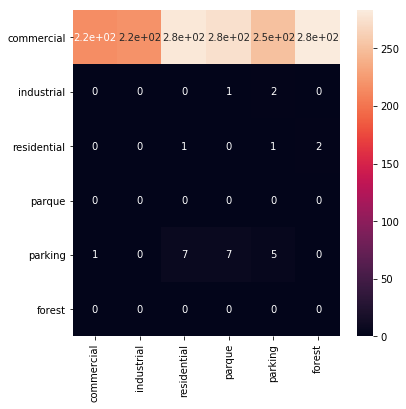

In [18]:
'Getting the true labels for the data predicted on'
#images = os.listdir(test_data_dir)
images = test_data
#images = images[:1500]

true_class         = []
true_class_indices = []
#images = os.listdir(test_data)
for i in range(len(images)):
    for k in range(len(classes)):
        if classes[k] in images[i]:
            true_class_indices.append(k)
            true_class.append(classes[k])

'Getting the count of each true label'
cnt = {}
for c in classes:
    cnt[c] = 0
    
for f in true_class:
    for c in classes:
        if c in f:
            cnt[c] += 1

print(len(true_class), cnt)

'Getting the count of predicted class'
cnt = {}
for c in classes:
    cnt[c] = 0
    
for f in predicted_class:
    for c in classes:
        if c in f:
            cnt[c] += 1

print(len(predicted_class), cnt)

'Check to see that the predicted amount is right'
print(len(true_class), len(predicted_class))
assert len(true_class) == len(predicted_class)

'Confusion matrix for the data'
conf_matrix = confusion_matrix(predicted_class_indices, true_class_indices)
print(conf_matrix)
print(predicted_class[0:10])
print(true_class[0:10])

'Plotting the confusion matrix'
df_cm = pd.DataFrame(conf_matrix, index = [i for i in classes],
                  columns = [i for i in classes])

plt.figure(figsize = (6, 6))
sn.heatmap(df_cm, annot=True)

## Keras evaluation generator

Using the keras evaluator to get test loss and test accuracy.

Perhaps just do it ourselves with the information provided from above?

In [15]:
model = ModelBuilder(curr_model, classes, input_shape=input_shape)

model = ModelBuilder(curr_model, classes, input_shape=input_shape)

'Loading the best weights for the trained model to be evaluated'
weight_folder = config['load-weights']['weights_folder']
weights =  config['load-weights']['weights']
model.load_weights(os.path.join(weight_folder, weights))

model.compile_model(optimizer=optimizer, 
                    loss=loss, 
                    metrics=metrics, 
                    learning_rate=lr)

test_datagen = DataGenerator(test_data_dir, test_data, classes,
                             n_channels=n_channels, dim=data_shape, 
                             batch_size=1, shuffle=False)

val_datagen = DataGenerator(train_data_dir, val_data, classes, 
                            n_channels=n_channels, dim=data_shape, 
                            batch_size=5)


'Testing keras evaluate'
scores = model.evaluate(val_datagen, 113)
print(scores)

(128, 128, 4)
(128, 128, 4)
113/113 [==============================] - 2s 20ms/step
[5734.47021484375, 0.16106194257736206]
